# Sheet properties

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt

# Start with local

In [2]:
import sys
from IPython.display import HTML
sys.path.append('/home/rcendre/classification')

# Imports

In [3]:
import os
import sys
import itertools
import webbrowser
from pathlib import Path
import matplotlib.pyplot as plt
from numpy import array, logspace
from scipy.stats import randint as randint
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import davies_bouldin_score
from toolbox.classification.common import Data, Folds, IO, Tools
from toolbox.classification.parameters import Dermatology, Settings
from toolbox.IO import dermatology
from toolbox.models.builtin import Applications
from toolbox.models.models import DecisionVotingClassifier, ScoreVotingClassifier
from toolbox.transforms.common import PredictorTransform
from toolbox.transforms.labels import OrderedEncoder
from toolbox.transforms.images import DistributionImageTransform, DWTImageTransform, FourierImageTransform, HaralickImageTransform, SpatialImageTransform
from toolbox.views.common import Views, ViewsTools
from toolbox.views.images import ImagesViews
from IPython.display import display

Using TensorFlow backend.


# Parameters

In [4]:
# Advanced parameters
data_type = 'Full'
validation = 4
statistics = Dermatology.get_statistics_keys()
settings = Settings.get_default_dermatology()

In [5]:
diagnosis_encoder = OrderedEncoder().fit(['Benign', 'Malignant'])
malignant_encoder = OrderedEncoder().fit(['Rest', 'Malignant'])

In [6]:
extractor = 'InceptionResNetV2'

# Inputs

In [7]:
file = f'Transfer_{data_type}.pickle'
inputs = IO.load(file)
inputs = inputs[(inputs['Binary_Diagnosis'] == 'Benign') |(inputs['Binary_Diagnosis'] == 'Malignant')].reset_index(drop=True)
inputs_first = inputs['ImageID'] == '0M'

In [8]:
all_file = f'All_Transfer_{data_type}.pickle'
all_inputs = IO.load(all_file)
all_inputs = all_inputs[(all_inputs['Binary_Diagnosis'] == 'Benign') |(all_inputs['Binary_Diagnosis'] == 'Malignant')].reset_index(drop=True)
all_inputs_first = all_inputs['ImageID'] == '0M'

# Samples statistics

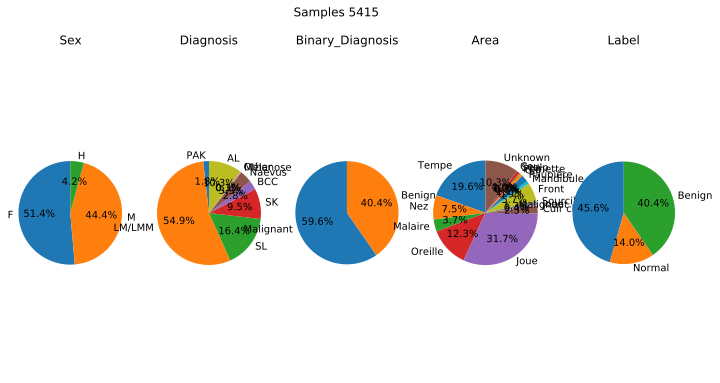

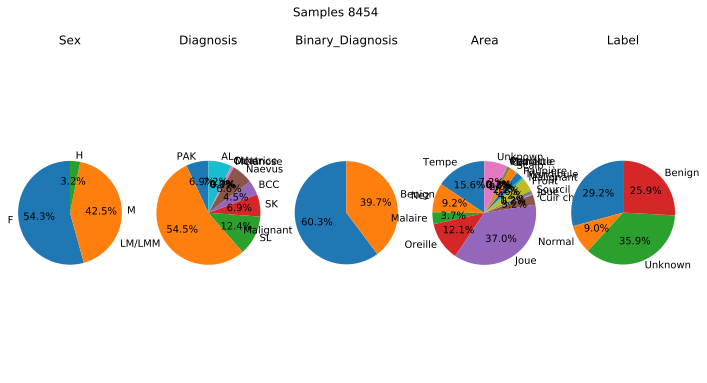

In [11]:
ViewsTools.plot_size((12, 6))
Views.statistics(inputs, statistics);

ViewsTools.plot_size((12, 6))
Views.statistics(all_inputs, statistics);

# Label / Group / Fold

In [12]:
# Transform labels
Tools.transform(inputs, {'datum': 'Binary_Diagnosis'}, diagnosis_encoder, 'DiagnosisEncode')
Tools.transform(inputs, {'datum': 'Malignant'}, malignant_encoder, 'MalignantEncode')
# Transform groups
group_encoder = LabelEncoder().fit(array(inputs['ID'].tolist()))
Tools.transform(inputs, {'datum': 'ID'}, group_encoder, 'GroupEncode')
# Make folds
Folds.build_group_folds(inputs, {'datum': 'Datum', 'label_encode': 'MalignantEncode', 'group': 'GroupEncode'}, validation)

In [9]:
# Transform labels
Tools.transform(all_inputs, {'datum': 'Binary_Diagnosis'}, diagnosis_encoder, 'DiagnosisEncode')
Tools.transform(all_inputs, {'datum': 'Malignant'}, malignant_encoder, 'MalignantEncode')
# Transform groups
group_encoder = LabelEncoder().fit(array(all_inputs['ID'].tolist()))
Tools.transform(all_inputs, {'datum': 'ID'}, group_encoder, 'GroupEncode')
# Make folds
Folds.build_group_folds(all_inputs, {'datum': 'Datum', 'label_encode': 'DiagnosisEncode', 'group': 'GroupEncode'}, validation)

# Low level predictions

In [13]:
low_file = f'Low_Transfer_{data_type}.pickle'
low_all_file = f'Low_All_Transfer_{data_type}.pickle'

In [15]:
grid = {'clf__C': logspace(-2, 3, 6).tolist()}
# Add scaling step
supervised = Pipeline([ ('scale', StandardScaler()), ('clf', SVC(kernel='linear', class_weight='balanced', probability=True))])

In [16]:
# Transform standard inputs
Tools.fit_predict(inputs, {'datum': extractor, 'label_encode': 'MalignantEncode'}, supervised, 'Supervised', grid=grid, predict_mode='validation')

# Save
IO.save(inputs, low_file)

In [17]:
# Add scaling
Tools.fit_predict(all_inputs, {'datum': extractor, 'label_encode': 'MalignantEncode'}, supervised, 'Supervised', grid=grid, predict_mode='validation')

# Low Level
IO.save(all_inputs, low_all_file)

In [14]:
inputs = IO.load(low_file)
all_inputs = IO.load(low_all_file)

# High level predictions

In [10]:
high_file = f'High_Transfer_{data_type}.pickle'
high_all_file = f'High_All_Transfer_{data_type}.pickle'
norms = {'p_norm': [6, 8, 10, 20]}

In [11]:
Data.build_bags(inputs, inputs_first, 'ID', [True] * len(inputs.index), 'ID', f'Supervised_{Tools.PREDICTION}')
Data.build_bags(inputs, inputs_first, 'ID', [True] * len(inputs.index), 'ID', f'Supervised_{Tools.PROBABILITY}')

Data.build_bags(all_inputs, all_inputs_first, 'ID', [True] * len(all_inputs.index), 'ID', f'Supervised_{Tools.PREDICTION}')
Data.build_bags(all_inputs, all_inputs_first, 'ID', [True] * len(all_inputs.index), 'ID', f'Supervised_{Tools.PROBABILITY}')

In [12]:
# Decisions
Tools.evaluate(inputs, {'datum': f'Supervised_{Tools.PREDICTION}', 'label_encode': 'DiagnosisEncode'}, DecisionVotingClassifier(mode='at_least_one'), 'D_ALO', mask=inputs_first, predict_mode='on_validation')
Tools.evaluate(inputs, {'datum': f'Supervised_{Tools.PREDICTION}', 'label_encode': 'DiagnosisEncode'}, DecisionVotingClassifier(mode='dynamic_thresh'), 'D_DYN', mask=inputs_first, predict_mode='on_validation')

# Score
Tools.evaluate(inputs, {'datum': f'Supervised_{Tools.PROBABILITY}', 'label_encode': 'DiagnosisEncode'}, ScoreVotingClassifier(low='max', high='dynamic'), 'S_MaxD', mask=inputs_first, predict_mode='on_validation')
Tools.evaluate(inputs, {'datum': f'Supervised_{Tools.PROBABILITY}', 'label_encode': 'DiagnosisEncode'}, ScoreVotingClassifier(low='mean', high='dynamic'), 'S_MeanD', mask=inputs_first, predict_mode='on_validation')
Tools.evaluate(inputs, {'datum': f'Supervised_{Tools.PROBABILITY}', 'label_encode': 'DiagnosisEncode'}, ScoreVotingClassifier(low='p-norm', high='dynamic', is_prior_max=True), 'S_NormD', grid=norms, mask=inputs_first, predict_mode='on_validation')

# High Level
IO.save(inputs, high_file)

Exception: Need to build fold.

In [15]:
# Decisions
Tools.evaluate(all_inputs, {'datum': f'Supervised_{Tools.PREDICTION}', 'label_encode': 'DiagnosisEncode'}, DecisionVotingClassifier(mode='at_least_one'), 'D_ALO', mask=all_inputs_first, predict_mode='on_validation')
Tools.evaluate(all_inputs, {'datum': f'Supervised_{Tools.PREDICTION}', 'label_encode': 'DiagnosisEncode'}, DecisionVotingClassifier(mode='dynamic_thresh'), 'D_DYN', mask=all_inputs_first, predict_mode='on_validation')

# Score
Tools.evaluate(all_inputs, {'datum': f'Supervised_{Tools.PROBABILITY}', 'label_encode': 'DiagnosisEncode'}, ScoreVotingClassifier(low='max', high='dynamic'), 'S_MaxD', mask=all_inputs_first, predict_mode='on_validation')
Tools.evaluate(all_inputs, {'datum': f'Supervised_{Tools.PROBABILITY}', 'label_encode': 'DiagnosisEncode'}, ScoreVotingClassifier(low='mean', high='dynamic'), 'S_MeanD', mask=all_inputs_first, predict_mode='on_validation')
Tools.evaluate(all_inputs, {'datum': f'Supervised_{Tools.PROBABILITY}', 'label_encode': 'DiagnosisEncode'}, ScoreVotingClassifier(low='p-norm', high='dynamic', is_prior_max=True), 'S_NormD', grid=norms, mask=all_inputs_first, predict_mode='on_validation')

# High Level
IO.save(all_inputs, high_all_file)

AttributeError: 'float' object has no attribute 'size'

# Analysis

## Scores and ROC

,Fold,Features,Parameters
0,1,0,{}
1,2,0,{}
2,3,0,{}
3,4,0,{}


,f1-score,precision,recall,support
Benign,0.57±0.07,0.97±0.04,0.41±0.07,86.00±2.87
Malignant,0.79±0.07,0.66±0.09,0.99±0.02,99.00±4.76
micro avg,0.72±0.07,0.72±0.07,0.72±0.07,185.00±2.49
macro avg,0.68±0.06,0.81±0.06,0.70±0.04,185.00±2.49
weighted avg,0.69±0.08,0.80±0.04,0.72±0.07,185.00±2.49
,f1-score,precision,recall,support
Benign,0.57±0.07,0.97±0.04,0.41±0.07,258.00±8.62
Malignant,0.79±0.07,0.66±0.09,0.99±0.02,297.00±14.29
micro avg,0.72±0.07,0.72±0.07,0.72±0.07,555.00±7.46
macro avg,0.68±0.06,0.81±0.06,0.70±0.04,555.00±7.46


,Fold,Features,Parameters
0,1,0,{}
1,2,0,{}
2,3,0,{}
3,4,0,{}


,f1-score,precision,recall,support
Benign,0.86±0.07,0.86±0.08,0.86±0.11,86.00±2.87
Malignant,0.88±0.08,0.88±0.11,0.88±0.09,99.00±4.76
micro avg,0.87±0.07,0.87±0.07,0.87±0.07,185.00±2.49
macro avg,0.87±0.07,0.87±0.07,0.87±0.08,185.00±2.49
weighted avg,0.87±0.07,0.87±0.07,0.87±0.07,185.00±2.49
,f1-score,precision,recall,support
Benign,0.90±0.06,0.90±0.07,0.90±0.05,258.00±8.62
Malignant,0.91±0.08,0.91±0.07,0.92±0.09,297.00±14.29
micro avg,0.91±0.07,0.91±0.07,0.91±0.07,555.00±7.46
macro avg,0.91±0.07,0.91±0.07,0.91±0.07,555.00±7.46


,Fold,Features,Parameters
0,1,0,{}
1,2,0,{}
2,3,0,{}
3,4,0,{}


,f1-score,precision,recall,support
Benign,0.80±0.13,0.89±0.02,0.73±0.20,86.00±2.87
Malignant,0.85±0.09,0.80±0.14,0.92±0.02,99.00±4.76
micro avg,0.83±0.10,0.83±0.10,0.83±0.10,185.00±2.49
macro avg,0.83±0.11,0.84±0.08,0.83±0.10,185.00±2.49
weighted avg,0.83±0.11,0.84±0.08,0.83±0.10,185.00±2.49
,f1-score,precision,recall,support
Benign,0.86±0.05,0.89±0.07,0.84±0.09,258.00±8.62
Malignant,0.88±0.07,0.86±0.07,0.91±0.10,297.00±14.29
micro avg,0.87±0.05,0.87±0.05,0.87±0.05,555.00±7.46
macro avg,0.87±0.05,0.88±0.05,0.87±0.06,555.00±7.46


,Fold,Features,Parameters
0,1,0,{}
1,2,0,{}
2,3,0,{}
3,4,0,{}


,f1-score,precision,recall,support
Benign,0.84±0.10,0.82±0.12,0.86±0.15,86.00±2.87
Malignant,0.86±0.10,0.87±0.14,0.84±0.14,99.00±4.76
micro avg,0.85±0.10,0.85±0.10,0.85±0.10,185.00±2.49
macro avg,0.85±0.10,0.85±0.09,0.85±0.09,185.00±2.49
weighted avg,0.85±0.10,0.85±0.08,0.85±0.10,185.00±2.49
,f1-score,precision,recall,support
Benign,0.88±0.02,0.86±0.05,0.90±0.04,258.00±8.62
Malignant,0.89±0.06,0.91±0.05,0.87±0.09,297.00±14.29
micro avg,0.88±0.04,0.88±0.04,0.88±0.04,555.00±7.46
macro avg,0.88±0.04,0.88±0.04,0.88±0.04,555.00±7.46


,Fold,Features,Parameters
0,1,0,{'p_norm': 10}
1,2,0,{'p_norm': 6}
2,3,0,{'p_norm': 20}
3,4,0,{'p_norm': 6}


,f1-score,precision,recall,support
Benign,0.82±0.11,0.87±0.02,0.78±0.19,86.00±2.87
Malignant,0.86±0.08,0.82±0.15,0.90±0.03,99.00±4.76
micro avg,0.84±0.10,0.84±0.10,0.84±0.10,185.00±2.49
macro avg,0.84±0.10,0.85±0.07,0.84±0.09,185.00±2.49
weighted avg,0.84±0.10,0.85±0.07,0.84±0.10,185.00±2.49
,f1-score,precision,recall,support
Benign,0.86±0.05,0.85±0.06,0.88±0.09,258.00±8.62
Malignant,0.88±0.07,0.89±0.07,0.87±0.12,297.00±14.29
micro avg,0.87±0.05,0.87±0.05,0.87±0.05,555.00±7.46
macro avg,0.87±0.05,0.87±0.04,0.87±0.06,555.00±7.46


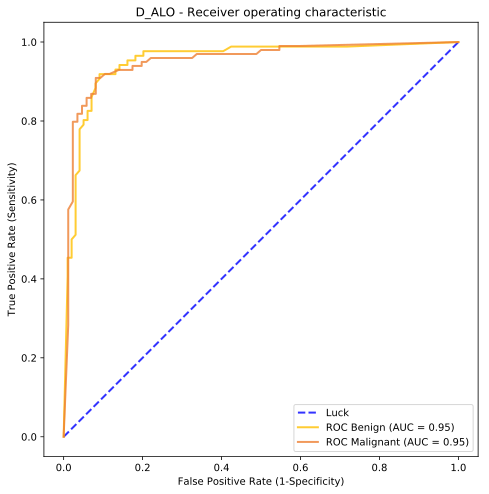

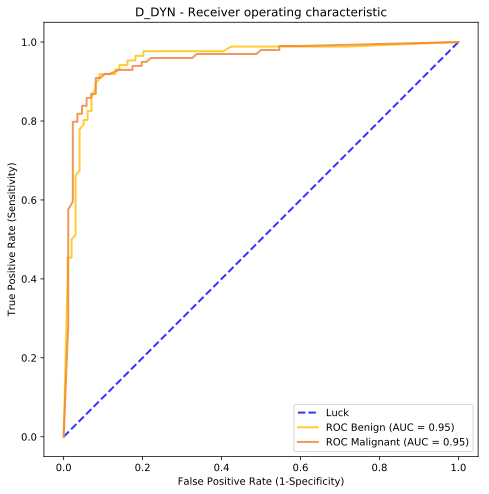

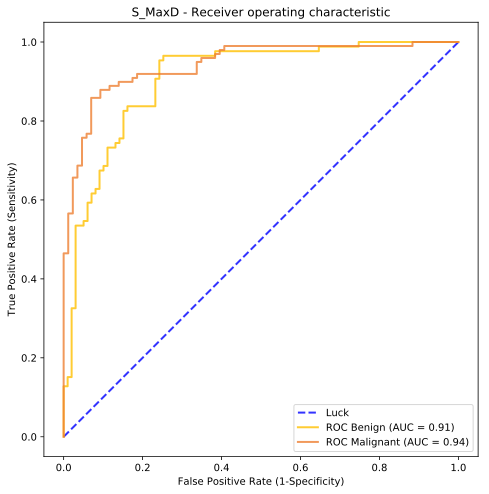

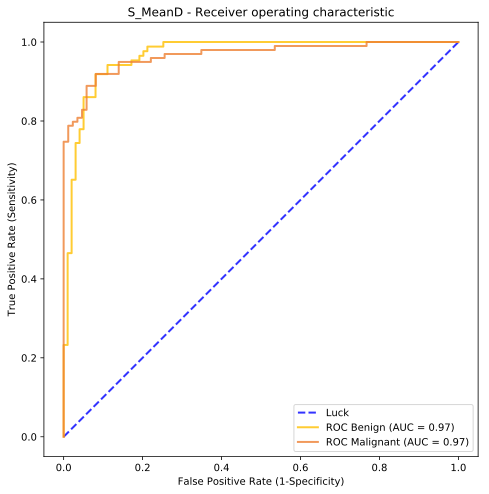

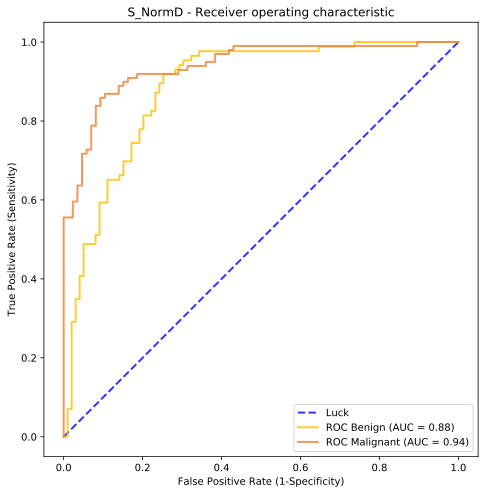

In [23]:
# ROC Curve
ViewsTools.plot_size((8,8))
high_models = ['D_ALO', 'D_DYN', 'S_MaxD', 'S_MeanD', 'S_NormD']
for model_name in high_models: 
    #Label
    display(Views.details(ViewsTools.data_as(inputs[inputs_first], model_name), {'eval': model_name}))
    display(HTML(ViewsTools.dataframe_renderer([Views.report(ViewsTools.data_as(inputs[inputs_first], model_name), {'label_encode': 'DiagnosisEncode', 'eval': model_name}, diagnosis_encoder),
                                Views.report(ViewsTools.data_as(inputs[inputs_first], model_name, as_train=True), {'label_encode': 'DiagnosisEncode', 'eval': model_name}, diagnosis_encoder)],
                                title=[f'Test - {model_name}', f'Train - {model_name}'])))   
    Views.receiver_operator_curves(ViewsTools.data_as(inputs[inputs_first], model_name), diagnosis_encoder, {'label_encode': 'DiagnosisEncode', 'eval': model_name}, settings);

,Fold,Features,Parameters
0,1,0,{}
1,2,0,{}
2,3,0,{}
3,4,0,{}


,f1-score,precision,recall,support
Benign,0.36±0.02,0.87±0.08,0.23±0.02,113.00±4.82
Malignant,0.75±0.05,0.61±0.07,0.97±0.02,138.00±5.22
micro avg,0.64±0.05,0.64±0.05,0.64±0.05,251.00±2.17
macro avg,0.56±0.03,0.74±0.02,0.60±0.01,251.00±2.17
weighted avg,0.57±0.06,0.72±0.03,0.64±0.05,251.00±2.17
,f1-score,precision,recall,support
Benign,0.36±0.02,0.87±0.08,0.23±0.02,339.00±14.45
Malignant,0.75±0.05,0.61±0.07,0.97±0.02,414.00±15.66
micro avg,0.64±0.05,0.64±0.05,0.64±0.05,753.00±6.50
macro avg,0.56±0.03,0.74±0.02,0.60±0.01,753.00±6.50


,Fold,Features,Parameters
0,1,0,{}
1,2,0,{}
2,3,0,{}
3,4,0,{}


,f1-score,precision,recall,support
Benign,0.83±0.06,0.86±0.06,0.81±0.06,113.00±4.82
Malignant,0.87±0.02,0.85±0.03,0.89±0.03,138.00±5.22
micro avg,0.85±0.03,0.85±0.03,0.85±0.03,251.00±2.17
macro avg,0.85±0.03,0.85±0.03,0.85±0.04,251.00±2.17
weighted avg,0.85±0.03,0.85±0.03,0.85±0.03,251.00±2.17
,f1-score,precision,recall,support
Benign,0.83±0.06,0.85±0.07,0.81±0.07,339.00±14.45
Malignant,0.86±0.02,0.85±0.05,0.88±0.03,414.00±15.66
micro avg,0.85±0.03,0.85±0.03,0.85±0.03,753.00±6.50
macro avg,0.85±0.04,0.85±0.04,0.84±0.04,753.00±6.50


,Fold,Features,Parameters
0,1,0,{}
1,2,0,{}
2,3,0,{}
3,4,0,{}


,f1-score,precision,recall,support
Benign,0.72±0.06,0.75±0.14,0.70±0.17,113.00±4.82
Malignant,0.78±0.05,0.77±0.12,0.80±0.14,138.00±5.22
micro avg,0.76±0.04,0.76±0.04,0.76±0.04,251.00±2.17
macro avg,0.75±0.04,0.76±0.01,0.75±0.02,251.00±2.17
weighted avg,0.76±0.05,0.76±0.01,0.76±0.04,251.00±2.17
,f1-score,precision,recall,support
Benign,0.77±0.05,0.82±0.08,0.73±0.05,339.00±14.45
Malignant,0.83±0.02,0.80±0.04,0.87±0.05,414.00±15.66
micro avg,0.81±0.02,0.81±0.02,0.81±0.02,753.00±6.50
macro avg,0.80±0.03,0.81±0.03,0.80±0.03,753.00±6.50


,Fold,Features,Parameters
0,1,0,{}
1,2,0,{}
2,3,0,{}
3,4,0,{}


,f1-score,precision,recall,support
Benign,0.81±0.07,0.82±0.11,0.79±0.14,113.00±4.82
Malignant,0.85±0.03,0.83±0.12,0.86±0.08,138.00±5.22
micro avg,0.83±0.05,0.83±0.05,0.83±0.05,251.00±2.17
macro avg,0.83±0.05,0.83±0.05,0.82±0.05,251.00±2.17
weighted avg,0.83±0.05,0.83±0.04,0.83±0.05,251.00±2.17
,f1-score,precision,recall,support
Benign,0.82±0.07,0.83±0.09,0.81±0.06,339.00±14.45
Malignant,0.85±0.03,0.85±0.03,0.86±0.04,414.00±15.66
micro avg,0.84±0.04,0.84±0.04,0.84±0.04,753.00±6.50
macro avg,0.84±0.05,0.84±0.05,0.84±0.05,753.00±6.50


,Fold,Features,Parameters
0,1,0,{'p_norm': 8}
1,2,0,{'p_norm': 10}
2,3,0,{'p_norm': 8}
3,4,0,{'p_norm': 6}


,f1-score,precision,recall,support
Benign,0.74±0.09,0.75±0.15,0.73±0.19,113.00±4.82
Malignant,0.79±0.08,0.78±0.14,0.80±0.15,138.00±5.22
micro avg,0.76±0.08,0.76±0.08,0.76±0.08,251.00±2.17
macro avg,0.76±0.08,0.76±0.06,0.76±0.06,251.00±2.17
weighted avg,0.76±0.08,0.76±0.05,0.76±0.08,251.00±2.17
,f1-score,precision,recall,support
Benign,0.80±0.07,0.81±0.11,0.78±0.06,339.00±14.45
Malignant,0.84±0.04,0.83±0.01,0.85±0.09,414.00±15.66
micro avg,0.82±0.05,0.82±0.05,0.82±0.05,753.00±6.50
macro avg,0.82±0.05,0.82±0.05,0.82±0.05,753.00±6.50


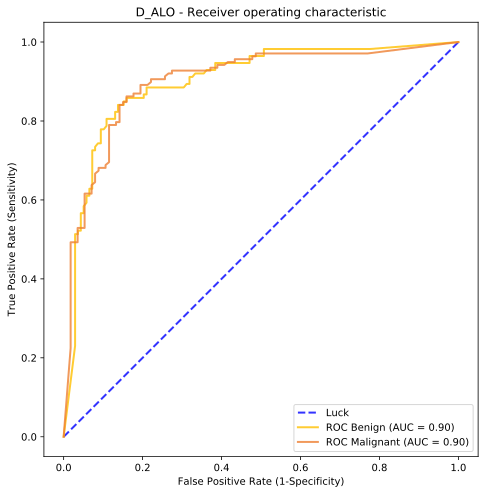

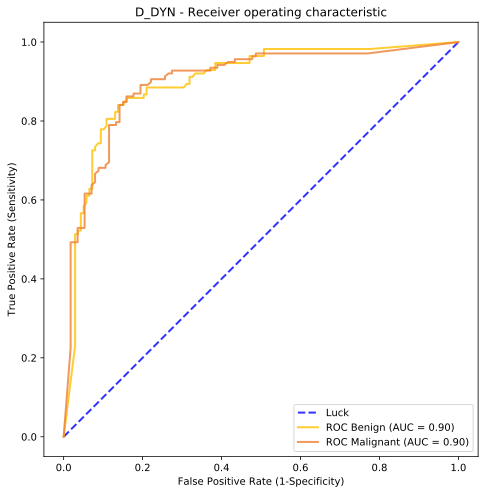

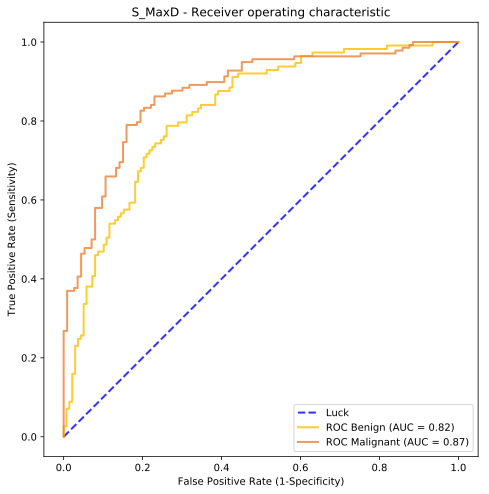

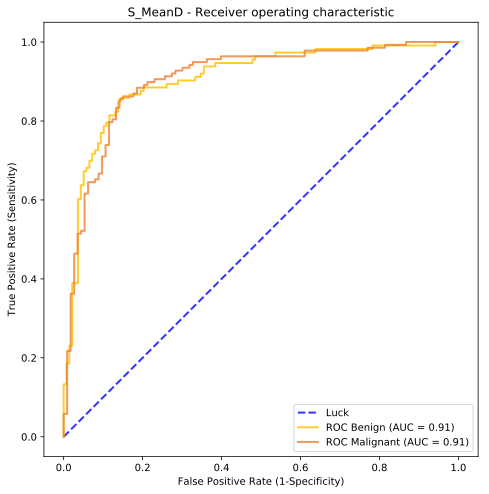

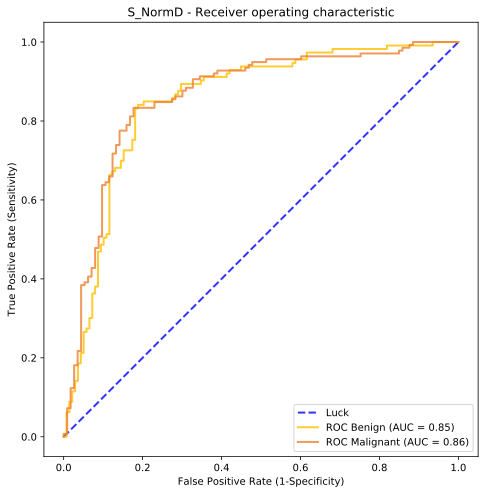

In [24]:
# ROC Curve
ViewsTools.plot_size((8,8))
high_models = ['D_ALO', 'D_DYN', 'S_MaxD', 'S_MeanD', 'S_NormD']
for model_name in high_models: 
    #Label
    display(Views.details(ViewsTools.data_as(all_inputs[all_inputs_first], model_name), {'eval': model_name}))
    display(HTML(ViewsTools.dataframe_renderer([Views.report(ViewsTools.data_as(all_inputs[all_inputs_first], model_name), {'label_encode': 'DiagnosisEncode', 'eval': model_name}, diagnosis_encoder),
                                Views.report(ViewsTools.data_as(all_inputs[all_inputs_first], model_name, as_train=True), {'label_encode': 'DiagnosisEncode', 'eval': model_name}, diagnosis_encoder)],
                                title=[f'Test - {model_name}', f'Train - {model_name}'])))   
    Views.receiver_operator_curves(ViewsTools.data_as(all_inputs[all_inputs_first], model_name), diagnosis_encoder, {'label_encode': 'DiagnosisEncode', 'eval': model_name}, settings);